Есть 2 таблицы: лог звонков по обработке анкет и таблица с анкетами и их характеристиками. Данные в них приведены за 2 дня. Решите две задачи с применением SQL (если видите варианты решения с другими  инструментами  - будет плюсом, если вы их опишете). 

In [1]:
import sqlite3
import pandas as pd

In [2]:
logs = pd.read_excel('1 Логи КЦ.xlsx')
forms = pd.read_excel('2 Анкеты.xlsx')

In [3]:
logs.head()

,START_TIME,Дата окон_звонка,RECIVED,FINISHED,EXPIRATION_TIME,APPID,PRD,COMM,RESULT,Дата,Неделя,Месяц,Год
0,2019-03-12 09:11:58,2019-03-12 09:29:41,2019-03-11 23:54:27,2019-03-12 09:29:42,2019-03-12 09:51:58,FICCBI20190311036583,CCBI,Заказана в ДО,Обратится в Отделение,2019-03-11,11,3,2019
1,2019-03-12 05:34:04,2019-03-12 05:34:15,2019-03-11 23:53:07,2019-03-12 10:04:44,2019-03-12 06:14:04,FICCBI20190311036573,CCBI,чп,NaN,2019-03-11,11,3,2019
2,2019-03-12 09:41:51,2019-03-12 10:04:44,2019-03-11 23:53:07,2019-03-12 10:04:44,2019-03-12 10:21:51,FICCBI20190311036573,CCBI,NaN,Анкета дозаполнена. Заявка на доставку заведена,2019-03-11,11,3,2019
3,2019-03-12 04:42:18,2019-03-12 04:43:27,2019-03-11 23:52:48,2019-03-12 09:55:31,2019-03-12 05:22:18,F0TDRC20S19031117458,CCBI,чп,NaN,2019-03-11,11,3,2019
4,2019-03-12 09:47:54,2019-03-12 09:55:31,2019-03-11 23:52:48,2019-03-12 09:55:31,2019-03-12 10:27:54,F0TDRC20S19031117458,CCBI,NaN,Анкета дозаполнена. Заявка заведена,2019-03-11,11,3,2019


In [4]:
forms.head()

,Id заявка,flecs_CREATEDATETIME,Скоринг М,Скоринг R,Тип доставки,Дата заключения договора,Договор заключен?,Город,Дата назначеной встречи,sf_channel,flecs_last_APPID,Запрашиваем сумма
0,FICCBI20190320018760,2019-03-20 13:51:00.3280000,0,0,NaN,NaN,NaN,Волгоград,NaN,03. Партнерки,F0TDRC20S19032009159,30000.0
1,FICCBI20190320007157,2019-03-20 10:10:25.1600000,0,0,NaN,NaN,NaN,Белгород,NaN,03. Партнерки,F0TCRC20S19032003281,55000.0
2,FICCBI20190320032250,2019-03-20 18:39:35.1650000,0,0,NaN,NaN,NaN,Москва,NaN,03. Партнерки,F0WDRG20S19032111800,100000.0
3,FICCBI20190320037217,2019-03-20 22:45:25.8310000,0,0,Курьер,NaN,NaN,Ростов-на-Дону,NaN,03. Партнерки,F0TDRC20S19032018096,100000.0
4,FICCBI20190320006818,2019-03-20 10:03:24.9700000,0,0,NaN,NaN,NaN,Москва,NaN,03. Партнерки,F0TDRC20S19032003129,50000.0


In [5]:
with sqlite3.connect('db') as conn:
    logs.to_sql(name='logs', con=conn, index=False, if_exists='replace')
    forms.to_sql(name='forms', con=conn, index=False, if_exists='replace')

In [6]:
conn = sqlite3.connect('db')

a.  Расчет SLA в разрезе городов динамике по дням. Есть целевое значение SLA для периода времени с 9:00 до 20:30. Именно для этого промежутка времени необходимо рассчитать фактический SLA. Целевое значение - оператор должен позвонить клиенту в течение 1 часа после получения заявки. 
Примечания: 
1) расчет нужен только для кредитных карт (обозначение CCBI); 
2) время в таблице логов указано московское, тогда как регионы клиентов могут быть разными; 
3) время начала звонка - start_time, время поступления заявки - recieved; 
4) у разных городов установлены разные приоритеты. 

i.  Напишите запрос, который позволит рассчитать нужный показатель, и приведите его в ответе на задание. 

In [7]:
query1 = """
SELECT
    Город,
    DATE(Дата) AS "Дата",
    COUNT() AS "Всего заявок",
    /* проверка на то что звонок был совершён в течение часа */
    SUM(CASE WHEN julianday(START_TIME) - julianday(RECIVED) <= 0.0416666 THEN 1 ELSE 0 END) AS SLA
FROM
    logs l
    LEFT JOIN forms f ON l.APPID = f."Id заявка"
    LEFT JOIN (
        SELECT
            l.APPID,
            COUNT(*) AS total_count
        FROM
            logs l
            LEFT JOIN forms f ON l.APPID = f."Id заявка"
        WHERE
            l.PRD = 'CCBI'
            AND START_TIME >= DATETIME(Дата, '+9 hours')
            AND START_TIME <= DATETIME(Дата, '+20 hours', '+30 minutes')
        GROUP BY
            l.APPID
    ) subquery ON l.APPID = subquery.APPID
WHERE
    l.PRD = 'CCBI'
    AND START_TIME >= DATETIME(Дата, '+9 hours')
    AND START_TIME <= DATETIME(Дата, '+20 hours', '+30 minutes')
GROUP BY
    f.Город,
    l.Дата
ORDER BY
    l.Дата,
    f.Город
"""

In [8]:
df1 = pd.read_sql(query1, conn)
df1

,Город,Дата,Всего заявок,SLA
0,None,2019-03-11,340,254
1,Барнаул,2019-03-11,14,9
2,Владивосток,2019-03-11,10,8
3,Волгоград,2019-03-11,7,7
4,Воронеж,2019-03-11,14,12
...,...,...,...,...
305,Тюмень,2019-03-20,29,1
306,Ульяновск,2019-03-20,4,4
307,Уфа,2019-03-20,47,5
308,Челябинск,2019-03-20,18,2


Как мы видим, для части заявок не подтянулся город. Это может быть связано с тем, что заяка была оставлена из неавторизованной зоны и определение города по провайдеру из кукисов не сработало/отсутствует как явление.

ii.  Результаты расчета визуализируйте в удобной для вас среде. 

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

C:\Users\Egor\AppData\Local\Temp\ipykernel_7552\2348011257.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


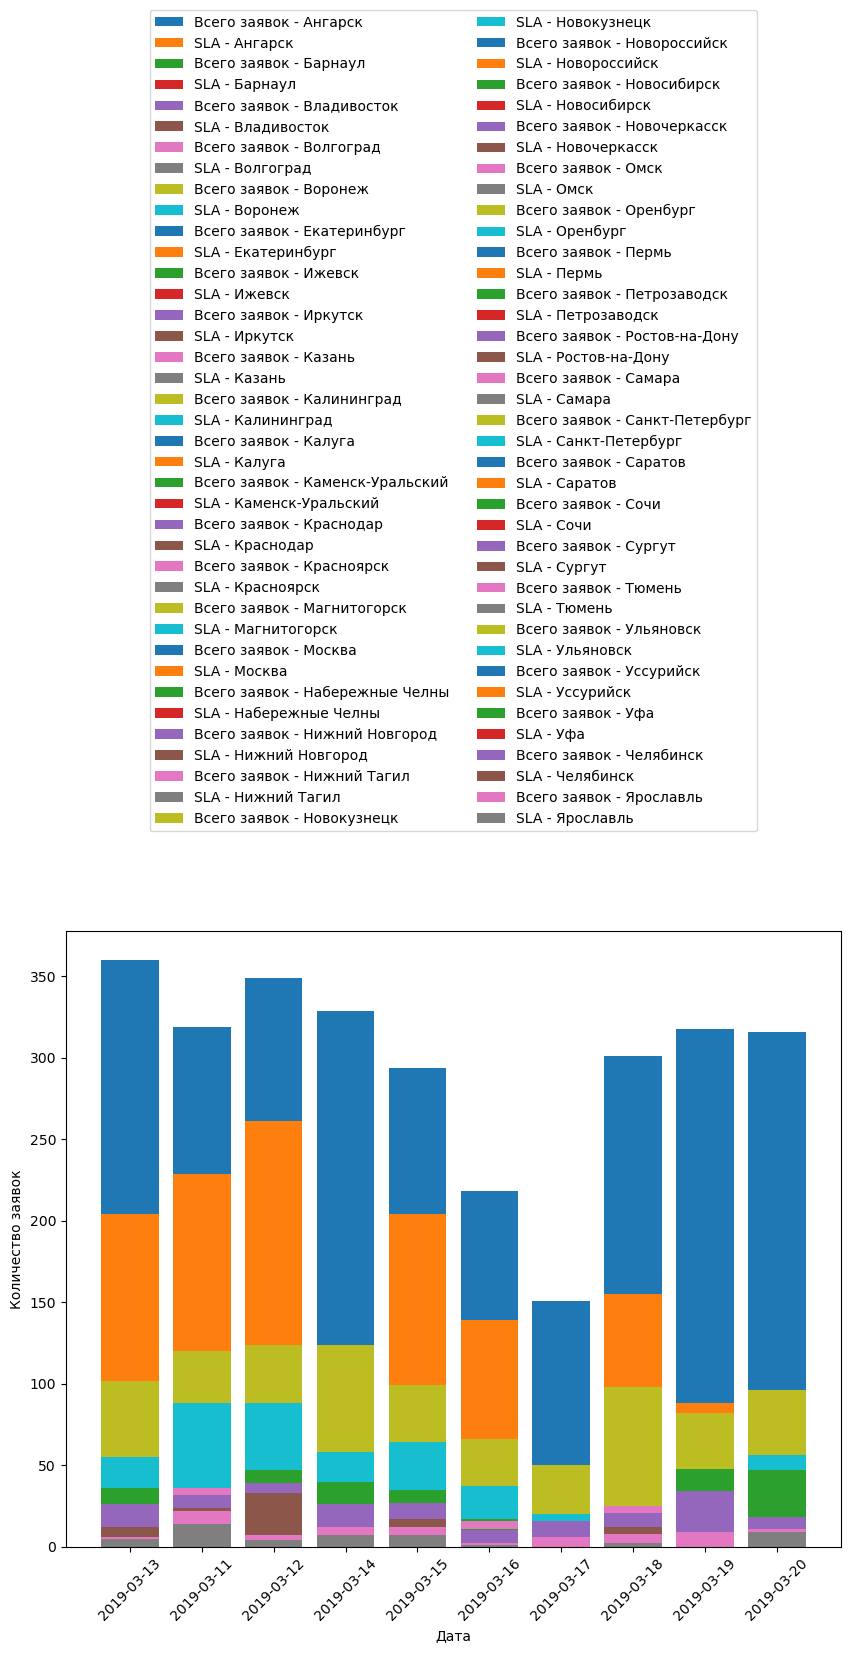

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

citygroups = df1.groupby('Город')

for name, group in citygroups:
    ax.bar(group['Дата'], group['Всего заявок'], label=f'Всего заявок - {name}')
    ax.bar(group['Дата'], group['SLA'], label=f'SLA - {name}')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')

ax.tick_params(axis='x', rotation=45)

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
plt.show()

iii.  Что может повлиять на изменение фактического SLA?

На изменение фактического SLA может повлиять изменение приоретизации по городам. К сожалению, информации, как эта приоретизация работает сейчас, у нас нет.
Я бы смотрел на количество поступаемых из конкретного города звонков и приоретизировал бы уже на этом основании.
А в идеале - наладить работу колл-центра так, чтобы количество операторов, по возможности, всегда перекрывало поступающие заявки. Для этого нужно посмотреть в разбивке по часам количество поступаемых звонков и выводить операторов на линию так, чтобы потребность в пиковые часы перекрывалась так, чтобы в среднем не происходило ситуации, когда нужно ждать звонка больше часа с момента поступления заявки.
Если операторы работают по ГПХ, это становится делать удобнее, т.к. там в этом случае не требуется держать операторов на линии полный рабочий день и можно выводить их на линию именно в нужные таймслоты, покрывая, таким образом, все часовые пояса.

b.        Расчет конверсии по  колл-центру в разрезе городов в динамике по дням. 
Примечания: 
1) строки с вхождением слов “заявка заведена” считается финальным статусом; 
2) если идентификаторы не  матчатся  - считайте это спецификой выгрузки. 

i.        Напишите запрос, который позволит рассчитать нужный показатель, и приведите его в ответе на задание. 

In [11]:
pd.read_sql("""
SELECT DATE(l.START_TIME) AS Дата, 
    f.Город, 
    COUNT(DISTINCT l.APPID) AS "Всего заявок",
    COUNT(DISTINCT CASE WHEN LOWER(l.RESULT) LIKE '%заявка%' AND LOWER(l.RESULT) LIKE '%заведена%' THEN l.APPID END) AS "Успешно заведенных",
    100.0 * COUNT(DISTINCT CASE WHEN LOWER(l.RESULT) LIKE '%заявка%' AND LOWER(l.RESULT) LIKE '%заведена%' THEN l.APPID END) / COUNT(DISTINCT l.APPID) AS "Конверсия"     
FROM logs l
JOIN forms f ON l.APPID = f."Id заявка"
GROUP BY f.Город, DATE(l.START_TIME)
ORDER BY f.Город, DATE(l.START_TIME)
""", conn)

,Дата,Город,Всего заявок,Успешно заведенных,Конверсия
0,2019-03-13,Ангарск,1,0,0.0
1,2019-03-11,Барнаул,10,0,0.0
2,2019-03-12,Барнаул,19,0,0.0
3,2019-03-13,Барнаул,28,0,0.0
4,2019-03-14,Барнаул,17,0,0.0
...,...,...,...,...,...
336,2019-03-17,Ярославль,10,0,0.0
337,2019-03-18,Ярославль,9,0,0.0
338,2019-03-19,Ярославль,12,0,0.0
339,2019-03-20,Ярославль,12,0,0.0


В запросе ниже я беру ключевое слово "заведена" без слова "заявка", исключая словосочетание "не заведена" и картина резко поменялась.

In [12]:
query2 = """
SELECT DATE(l.START_TIME) AS Дата, 
    f.Город, 
    COUNT(DISTINCT l.APPID) AS "Всего заявок",
    COUNT(DISTINCT CASE WHEN LOWER(l.RESULT) LIKE '%заведена%' AND LOWER(l.RESULT) NOT LIKE "не" THEN l.APPID END) AS "Успешно заведенных",
    100.0 * COUNT(DISTINCT CASE WHEN LOWER(l.RESULT) LIKE '%заведена%' AND LOWER(l.RESULT) NOT LIKE "не" THEN l.APPID END) / COUNT(DISTINCT l.APPID) AS "Конверсия"     
FROM logs l
LEFT JOIN forms f ON l.APPID = f."Id заявка"
GROUP BY DATE(l.START_TIME), f.Город
ORDER BY DATE(l.START_TIME), f.Город
"""

In [13]:
df2 = pd.read_sql(query2, conn)
df2

,Дата,Город,Всего заявок,Успешно заведенных,Конверсия
0,2019-03-11,None,1409,225,15.968772
1,2019-03-11,Барнаул,10,5,50.000000
2,2019-03-11,Владивосток,9,4,44.444444
3,2019-03-11,Волгоград,6,6,100.000000
4,2019-03-11,Воронеж,12,10,83.333333
...,...,...,...,...,...
347,2019-03-21,Челябинск,7,3,42.857143
348,2019-03-21,Ярославль,1,0,0.000000
349,2019-03-22,Иркутск,1,0,0.000000
350,2019-03-22,Красноярск,1,0,0.000000


ii.        Результаты расчета визуализируйте в удобной для вас среде. 

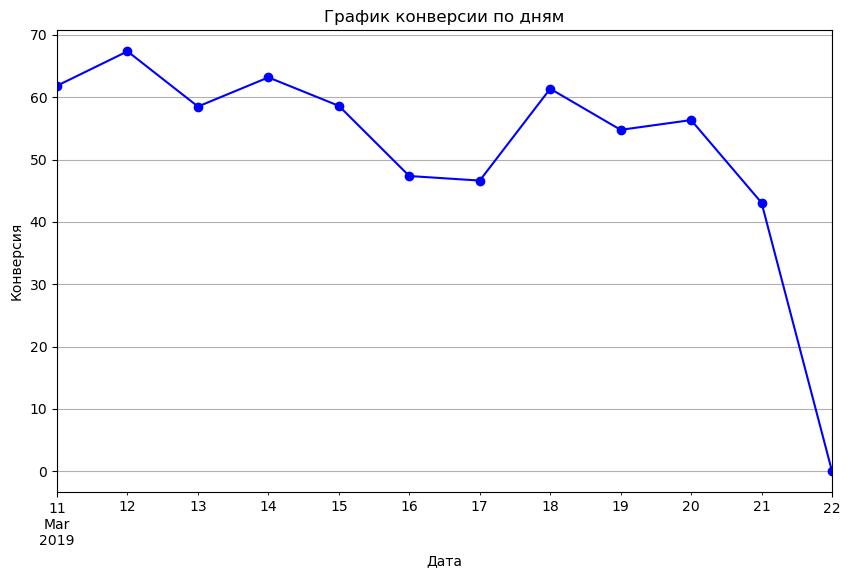

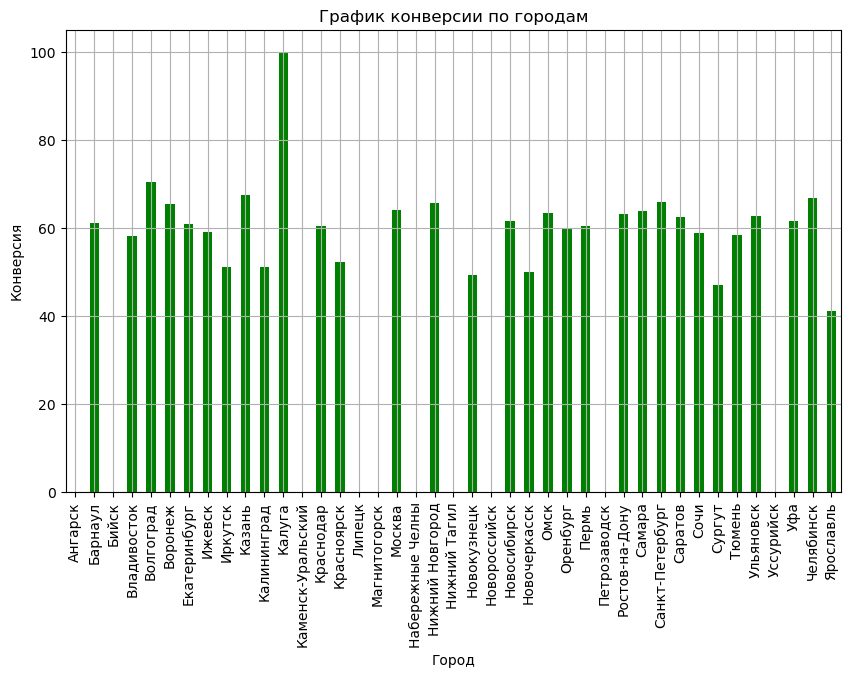

In [14]:
df2['Дата'] = pd.to_datetime(df2['Дата'])

plt.figure(figsize=(10, 6))
df2.groupby('Дата')['Конверсия'].mean().plot(marker='o', linestyle='-', color='b')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График конверсии по дням')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
df2.groupby('Город')['Конверсия'].mean().plot(kind='bar', color='g')
plt.xlabel('Город')
plt.ylabel('Конверсия')
plt.title('График конверсии по городам')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

iii.        Предложите варианты факторов, которые могут повлиять на падение конверсии?

Смотря что имеется в виду под падением конверсии. Если речь о том, что 22.03 идёт резкое падение, это связано, вероятнее всего, с тем, что данные за этот день данные ещё не успели в полном объёме попасть в источник, из которого они берутся.

Если брать причины падения конверсии в отрыве от выгрузки, одной из причин, особенно в маленьких городах, может являться наличие продукта и отказ по повторной заявке в виду наличия оной, если речь о кредитных продуктах, то по факту получения успешной активной заявки с ещё не закрытым договором мы имеем человека с информацией об имеющихся кредитах в БКИ, что делает шанс на одобрение новой заявки ещё меньшим, так же возможен вариант наличия такой заявки в другом банке и бесконечные дубли с попытками всё-таки получить одобренную заявку приводят к падению конверсию.
Отдельно было сказано про "особенно в маленьких городах", т.к. приток туда населения происходит гораздо меньший и, следовательно, процент тех (относительно всего населения), кто оставляет повторные заявки в таких городах выше.